In [1]:
import sys
sys.path.append('../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers

# Setup

In [3]:
SUMMARY_PATH = '../results/summaries'
VALID_RESPONSES_PATH = '../results/valid_responses'
PLOTS_PATH = '../results/plots'
io.validate_path(PLOTS_PATH)

In [4]:
vis.sns_reset()
vis.sns_paper_style()

# Data

In [5]:
# Load the summary data for each model
df_summary = io.pd.concat([io.read_csv(io.path_join(SUMMARY_PATH, f"experiments_{model}.csv")) for model in constants.LLMS], ignore_index=True)
df_summary.head(1)

,model,temperature,llm_provider,llm_model,date,time,task_name,task_param,task_attempt,llm_completion_tokens,llm_prompt_tokens,llm_total_tokens,result_is_valid,result_valid_flag,result_original_message,file_path,valid_attempt
0,deepseek-chat-v3.1,0.0,NaN,NaN,2025-10-09,14:00,biased_top_k,top_100_bias_citations_high,1,NaN,NaN,NaN,False,provider_error,API returned error response: Provider returned...,../data/data-temperature/temperature_0.0/confi...,False


# Temperature

## Validity of responses

In [25]:
group_columns = ['temperature', 'model', 'result_valid_flag']
df_normalized = df_summary[group_columns].groupby(group_columns, dropna=False).size().reset_index(name='counts')
df_normalized['normalized_counts'] = df_normalized['counts'] / df_normalized.groupby(group_columns[:-1], dropna=False)['counts'].transform('sum')
df_normalized.head(10)

,temperature,model,result_valid_flag,counts,normalized_counts
0,0.0,deepseek-chat-v3.1,invalid,8,0.210526
1,0.0,deepseek-chat-v3.1,provider_error,7,0.184211
2,0.0,deepseek-chat-v3.1,valid,23,0.605263
3,0.0,deepseek-r1-0528,invalid,4,0.121212
4,0.0,deepseek-r1-0528,provider_error,3,0.090909
5,0.0,deepseek-r1-0528,valid,26,0.787879
6,0.0,gemini-2.5-flash,invalid,45,0.818182
7,0.0,gemini-2.5-flash,valid,10,0.181818
8,0.0,gemini-2.5-flash-grounded,invalid,49,0.765625
9,0.0,gemini-2.5-flash-grounded,valid,15,0.234375


In [26]:
df_normalized.result_valid_flag.unique()

array(['invalid', 'provider_error', 'valid', 'verbose', 'tuncated-dict'],
      dtype=object)

In [27]:
df_normalized_valid = df_normalized.query("result_valid_flag in @constants.EXPERIMENT_OUTPUT_VALID_FLAGS").groupby(group_columns[:-1]).normalized_counts.sum().reset_index()
df_normalized_valid

,temperature,model,normalized_counts
0,0.0,deepseek-chat-v3.1,0.605263
1,0.0,deepseek-r1-0528,0.787879
2,0.0,gemini-2.5-flash,0.181818
3,0.0,gemini-2.5-flash-grounded,0.234375
4,0.0,gemini-2.5-pro,0.540541
...,...,...,...
145,2.0,mistral-medium-3,0.967742
146,2.0,mistral-small-3.2-24b,0.906250
147,2.0,qwen3-14b,0.036585
148,2.0,qwen3-235b-a22b-2507,0.422222


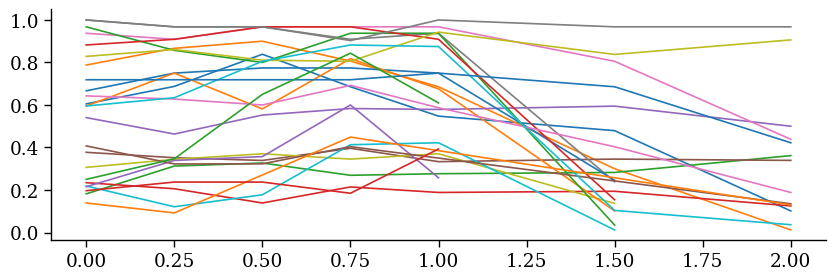

In [32]:
fig, ax = vis.plt.subplots(1,1,figsize=(10,3))

for model, df in df_normalized_valid.groupby('model'):
    ax.plot(df['temperature'], df['normalized_counts'], label=model)

vis.plt.show()
vis.plt.close()

In [ ]:
# check temprtature with max norm_count